#  어텐션 메커니즘 (Attention Mechanism)
앞서 배운 seq2seq 모델은 인코더에서 입력 시퀀스를 컨텍스트 벡터라는 하나의 고정된 크기의 벡터 표현으로 압축하고, 디코더는 이 컨텍스트 벡터를 통해서 출력 시퀀스를 만들어냈습니다.

하지만 이러한 RNN에 기반한 seq2seq 모델에는 크게 두 가지 문제가 있습니다.
첫째, 하나의 고정된 크기의 벡터에 모든 정보를 압축하려고 하니까 정보 손실이 발생합니다.
둘째, RNN의 고질적인 문제인 기울기 소실(vanishing gradient) 문제가 존재합니다.

결국 이는 기계 번역 분야에서 입력 문장이 길면 번역 품질이 떨어지는 현상으로 나타났습니다. 이를 위한 대안으로 입력 시퀀스가 길어지면 출력 시퀀스의 정확도가 떨어지는 것을 보정해주기 위한 등장한 기법인 어텐션(attention)을 소개합니다.

## 1. 어텐션(Attention)의 아이디어
어텐션의 기본 아이디어는 디코더에서 출력 단어를 예측하는 매 시점(time step)마다, 인코더에서의 전체 입력 문장을 다시 한 번 참고한다는 점입니다. 단, 전체 입력 문장을 전부 다 동일한 비율로 참고하는 것이 아니라, 해당 시점에서 예측해야할 단어와 연관이 있는 입력 단어 부분을 좀 더 집중(attention)해서 보게 됩니다.

## 2. 어텐션 함수(Attention Function)
어텐션 메커니즘을 언급하기 전에 컴퓨터공학의 많은 분야에서 사용되는 Key-Value로 구성되는 자료형에 대해서 잠깐 언급하겠습니다. 가령, 이 책의 주 언어로 사용되는 파이썬에도 Key-Value로 구성되는 자료형인 딕셔너리(Dict) 자료형이 존재합니다. 파이썬의 딕셔너리 자료형은 키(Key)와 값(Value)이라는 두 개의 쌍으로 구성되는데, 키를 통해서 맵핑된 값을 찾아낼 수 있다는 특징을 갖고있습니다.

#파이썬의 딕셔너리 자료형을 선언
#키(Key) : 값(value)의 형식으로 키와 값의 쌍(Pair)을 선언한다.
dict = {"2017" : "Transformer", "2018" : "BERT"}

위의 자료형에서 2017은 키에 해당되며, Transformer는 2017의 키와 맵핑되는 값에 해당됩니다. 그와 마찬가지로 2018은 키에 해당되며, BERT는 2018이라는 키와 맵핑되는 값에 해당됩니다.

print(dict["2017"]) #2017이라는 키에 해당되는 값을 출력
Transformer

print(dict["2018"])  #2018이라는 키에 해당되는 값을 출력
BERT

Key-Value 자료형에 대한 이해를 가지고 어텐션 함수에 대해서 설명해보겠습니다.

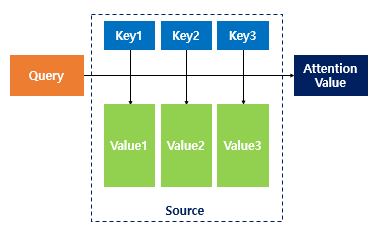

어텐션을 함수로 표현하면 주로 다음과 같이 표현됩니다.
Attention(Q, K, V) = Attention Value

어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구합니다. 그리고 구해낸 이 유사도를 키와 맵핑되어있는 각각의 '값(Value)'에 반영해줍니다. 그리고 유사도가 반영된 '값(Value)'을 모두 더해서 리턴합니다. 여기서는 이를 어텐션 값(Attention Value)이라고 하겠습니다.

지금부터 배우게 되는 seq2seq + 어텐션 모델에서 Q, K, V에 해당되는 각각의 Query, Keys, Values는 각각 다음과 같습니다.

Q = Query : t 시점의 디코더 셀에서의 은닉 상태
K = Keys : 모든 시점의 인코더 셀의 은닉 상태들
V = Values : 모든 시점의 인코더 셀의 은닉 상태들
간단한 어텐션 예제를 통해 어텐션을 이해해보겠습니다.

## 3. 닷-프로덕트 어텐션(Dot-Product Attention)
어텐션은 다양한 종류가 있는데 그 중에서도 가장 수식적으로 이해하기 쉽게 수식을 적용한 닷-프로덕트 어텐션(Dot-Product Attention)을 통해 어텐션을 이해해봅시다. seq2seq에서 사용되는 어텐션 중에서 닷-프로덕트 어텐션과 다른 어텐션의 차이는 주로 중간 수식의 차이로 메커니즘 자체는 거의 유사합니다.

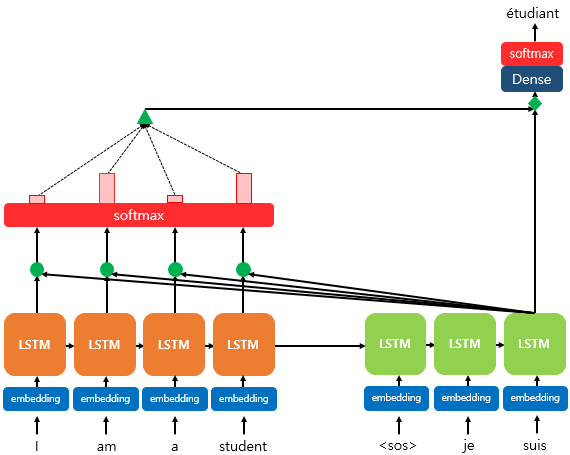


위 그림은 디코더의 세번째 LSTM 셀에서 출력 단어를 예측할 때, 어텐션 메커니즘을 사용하는 모습을 보여줍니다. 디코더의 첫번째, 두번째 LSTM 셀은 이미 어텐션 메커니즘을 통해 je와 suis를 예측하는 과정을 거쳤다고 가정합니다. 어텐션 메커니즘에 대해 상세히 설명하기 전에 위의 그림을 통해 전체적인 개요만 이해해보겠습니다. 디코더의 세번째 LSTM 셀은 출력 단어를 예측하기 위해서 인코더의 모든 입력 단어들의 정보를 다시 한번 참고하고자 합니다. 중간 과정에 대한 설명은 현재는 생략하고 여기서 주목할 것은 인코더의 소프트맥스 함수입니다.

소프트맥스 함수를 통해 나온 결과값은 I, am, a, student 단어 각각이 출력 단어를 예측할 때 얼마나 도움이 되는지의 정도를 수치화한 값입니다. 위의 그림에서는 빨간 직사각형의 크기로 소프트맥스 함수의 결과값의 크기를 표현했습니다. 직사각형의 크기가 클 수록 도움이 되는 정도의 크기가 큽니다. 각 입력 단어가 디코더의 예측에 도움이 되는 정도가 수치화하여 측정되면 이를 하나의 정보로 담아서 디코더로 전송됩니다. 위의 그림에서는 초록색 삼각형이 이에 해당됩니다. 결과적으로, 디코더는 출력 단어를 더 정확하게 예측할 확률이 높아집니다. 좀 더 상세히 알아보겠습니다.

###  1)어텐션 스코어(Attention Score)를 구한다.
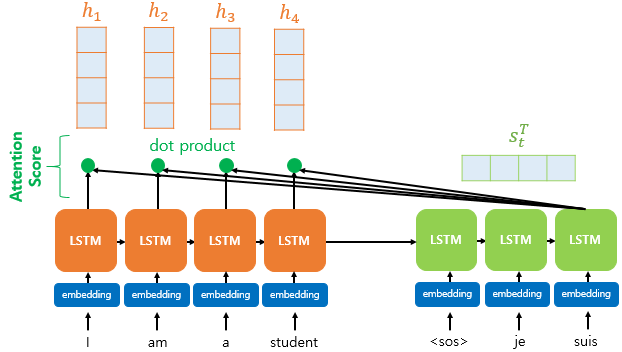

인코더의 시점(time step)을 각각 1, 2, ... N이라고 하였을 때 인코더의 은닉 상태(hidden state)를 각각 h1,h2,h3 ... hn라고 합시다. 디코더의 현재 시점(time step) t에서의 디코더의 은닉 상태(hidden state)를 st라고 합시다. 또한 여기서는 인코더의 은닉 상태와 디코더의 은닉 상태의 차원이 같다고 가정합니다. 위의 그림의 경우에는 인코더의 은닉 상태와 디코더의 은닉 상태가 동일하게 차원이 4입니다.

어텐션 메커니즘의 첫 걸음인 어텐션 스코어(Attention score)에 대해서 배우기전에, 이전 챕터 배웠던 디코더의 현재 시점 t에서 필요한 입력값을 다시 상기해보겠습니다. 시점 t에서 출력 단어를 예측하기 위해서 디코더의 셀은 두 개의 입력값을 필요로 하는데, 바로 이전 시점인 t-1의 은닉 상태와 이전 시점 t-1에 나온 출력 단어입니다.

그런데 어텐션 메커니즘에서는 출력 단어 예측에 또 다른 값을 필요로 하는데 바로 어텐션 값(Attention Value)이라는 새로운 값입니다. t번째 단어를 예측하기 위한 어텐션 값을 at이라고 정의하겠습니다.

어텐션 값이라는 새로운 개념이 등장한 만큼, 어텐션 값이 현재 시점 t에서의 출력 예측에 구체적으로 어떻게 반영되는지는 뒤에서 설명하겠습니다. 지금부터 배우는 모든 과정은 at를 구하기 위한 여정입니다. 그리고 그 여정의 첫 걸음은 바로 어텐션 스코어(Attention Score)를 구하는 일입니다. 어텐션 스코어란 현재 디코더의 시점 t에서 단어를 예측하기 위해, 인코더의 모든 은닉 상태 각각이 디코더의 현 시점의 은닉 상태 st와 얼마나 유사한지를 판단하는 스코어값입니다.

닷-프로덕트 어텐션에서는 이 스코어 값을 구하기 위해 
를 전치(transpose)하고 각 은닉 상태와 내적(dot product)을 수행합니다. 즉, 모든 어텐션 스코어 값은 스칼라입니다. 예를 들어 
과 인코더의 i번째 은닉 상태의 어텐션 스코어의 계산 방법은 아래와 같습니다.

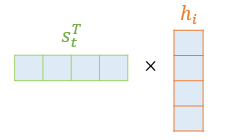

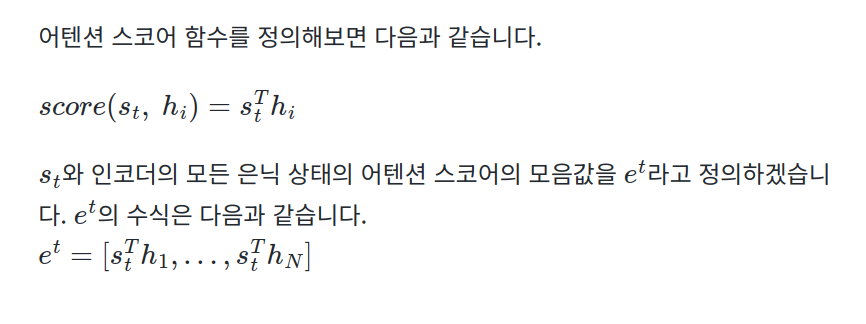

### 소프트맥스(softmax) 함수를 통해 어텐션 분포(Attention Distribution)를 구한다.
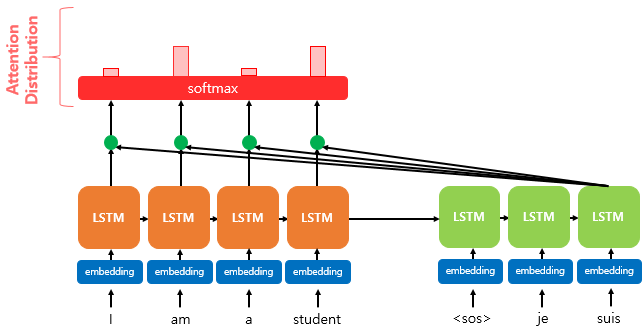

et에 소프트맥스 함수를 적용하여, 모든 값을 합하면 1이 되는 확률 분포를 얻어냅니다. 이를 어텐션 분포(Attention Distribution)라고 하며, 각각의 값은 어텐션 가중치(Attention Weight)라고 합니다. 예를 들어 소프트맥스 함수를 적용하여 얻은 출력값인 I, am, a, student의 어텐션 가중치를 각각 0.1, 0.4, 0.1, 0.4라고 합시다. 이들의 합은 1입니다. 위의 그림은 각 인코더의 은닉 상태에서의 어텐션 가중치의 크기를 직사각형의 크기를 통해 시각화하였습니다. 즉, 어텐션 가중치가 클수록 직사각형이 큽니다.

디코더의 시점 t에서의 어텐션 가중치의 모음값인 어텐션 분포를 at이라고 할 때, at을 식으로 정의하면 다음과 같습니다.

at=softmax(e**t)

### 3) 각 인코더의 어텐션 가중치와 은닉 상태를 가중합하여 어텐션 값(Attention Value)을 구한다.
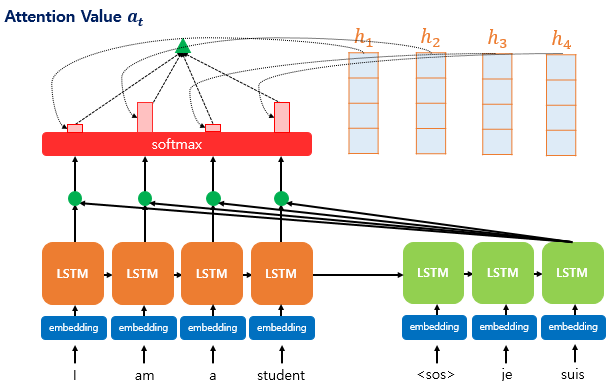

이제 지금까지 준비해온 정보들을 하나로 합치는 단계입니다. 어텐션의 최종 결과값을 얻기 위해서 각 인코더의 은닉 상태와 어텐션 가중치값들을 곱하고, 최종적으로 모두 더합니다. 요약하면 가중합(Weighted Sum)을 진행합니다. 아래는 어텐션의 최종 결과. 즉, 어텐션 함수의 출력값인 어텐션 값(Attention Value) at에 대한 식을 보여줍니다.
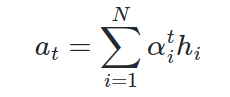

**이러한 어텐션 값 at은 종종 인코더의 문맥을 포함하고 있다고하여, 컨텍스트 벡터(context vector)라고도 불립니다. 앞서 배운 가장 기본적인 seq2seq에서는 인코더의 마지막 은닉 상태를 컨텍스트 벡터라고 부르는 것과 대조됩니다.**

### 4)어텐션 값과 디코더의 t 시점의 은닉 상태를 연결한다.(Concatenate)
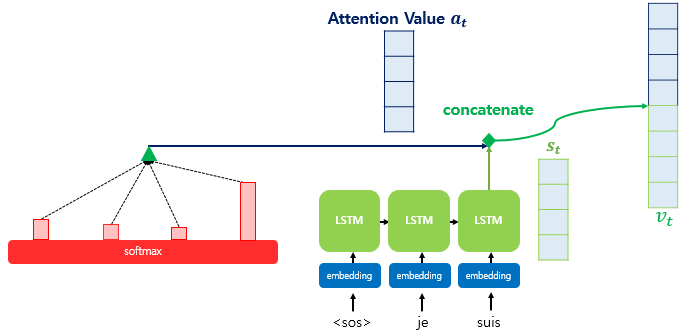

어텐션 함수의 최종값인 어텐션 값 at을 구했습니다. 사실 어텐션 값이 구해지면 어텐션 메커니즘은 at를 st와 결합(concatenate)하여 하나의 벡터로 만드는 작업을 수행합니다. 이를 
라고 정의해보겠습니다. 그리고 이 vt를 y^ 예측 연산의 입력으로 사용하므로서 인코더로부터 얻은 정보를 활용하여 y^를 좀 더 잘 예측할 수 있게 됩니다. 이것이 어텐션 메커니즘의 핵심입니다.

### 5) 출력층 연산의 입력이 되는 st**~를 계산합니다.
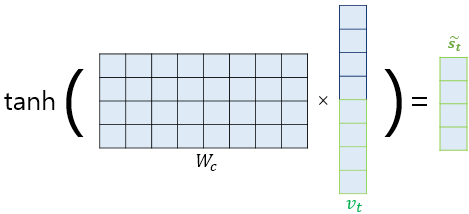

논문에서는 vt를 바로 출력층으로 보내기 전에 신경망 연산을 한 번 더 추가하였습니다. 가중치 행렬과 곱한 후에 하이퍼볼릭탄젠트 함수를 지나도록 하여 출력층 연산을 위한 새로운 벡터인 st**~를 얻습니다. 

어텐션 메커니즘을 사용하지 않는 seq2seq에서는 출력층의 입력이 t시점의 은닉 상태인 st였던 반면, 어텐션 메커니즘에서는 출력층의 입력이 st**~가 되는 셈입니다.

식으로 표현하면 다음과 같습니다. Wc는 학습 가능한 가중치 행렬, bc는 편향입니다. 그림에서 편향은 생략했습니다.

st**~=tanh(Wc[at;st]+b)

### st**~ 를 출력층의 입력으로 사용합니다.
st**~를 출력층의 입력으로 사용하여 예측 벡터를 얻습니다.

yt^=softmax(Wyst**~+by)

## 다양한 종류의 어텐션(Attention)
앞서 seq2seq + 어텐션(attention) 모델에 쓰일 수 있는 다양한 어텐션 종류가 있지만, 닷-프로덕트 어텐션과 다른 어텐션들의 차이는 중간 수식의 차이라고 언급한 바 있습니다. 여기서 말하는 중간 수식은 어텐션 스코어 함수를 말합니다. 위에서 배운 어텐션이 닷-프로덕트 어텐션인 이유는 어텐션 스코어를 구하는 방법이 내적이었기 때문입니다.

어텐션 스코어를 구하는 방법은 여러가지가 제시되어있으며, 현재 제시된 여러 종류의 어텐션 스코어 함수는 다음과 같습니다.

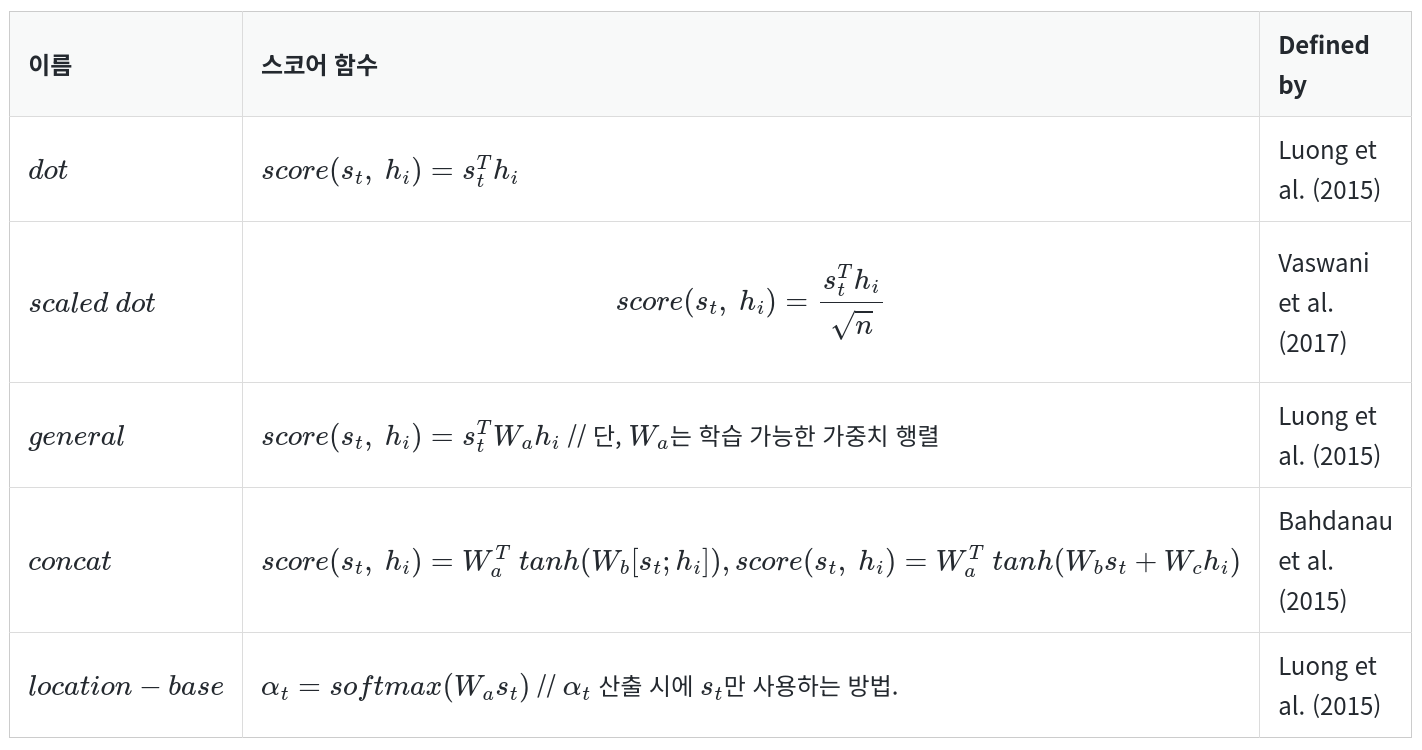

위에서 st는 Query, hu는 Keys, Wa와 Wb는 학습 가능한 가중치 행렬입니다.

이름이 dot이라고 붙여진 스코어 함수가 이번에 배운 닷 프로덕트 어텐션입니다. 이 어텐션은 제안한 사람의 이름을 따서 루옹(Luong) 어텐션이라고도 합니다. 제안한 이들의 이름은 위 테이블에서 Defined By에 적혀져 있습니다. concat이라는 이름의 어텐션은 만든 사람의 이름을 따서 바다나우(Bahdanau) 어텐션 이라고도 부르며 뒤에서 설명합니다.

지금까지 seq2seq에서 성능을 향상시켜주기 위한 기법인 어텐션에 대해서 알아봤습니다. 어텐션은 처음에는 RNN 기반의 seq2seq의 성능을 보정하기 위한 목적으로 소개되었지만, 현재에 이르러서는 어텐션 스스로가 기존의 seq2seq를 대체하는 방법이 되어가고 있습니다.

# 바다나우 어텐션(Bahdanau Attention)
앞서 어텐션 메커니즘의 목적과 어텐션 메커니즘의 일종인 닷 프로덕트 어텐션(루옹 어텐션)의 전체적인 개요를 살펴보고, 마지막에 표를 통해 그 외에도 다양한 어텐션 메커니즘이 존재한다고 소개하였습니다. 이번에는 닷 프로덕트 어텐션보다는 조금 더 복잡하게 설계된 바다나우 어텐션 메커니즘을 이해해봅시다.

## 바다나우 어텐션 함수(Bahdanau Attention Function)
어텐션 메커니즘을 함수 Attention()으로 정의하였을 때, 바다나우 어텐션 함수의 입, 출력은 다음과 같의 정의할 수 있습니다.

Attention(Q, K, V) = Attention Value

t = 어텐션 메커니즘이 수행되는 디코더 셀의 현재 시점을 의미.

Q = Query : t-1 시점의 디코더 셀에서의 은닉 상태
K = Keys : 모든 시점의 인코더 셀의 은닉 상태들
V = Values : 모든 시점의 인코더 셀의 은닉 상태들
여기서는 어텐션 함수의 Query가 디코더 셀의 t 시점의 은닉 상태가 아니라 t-1 시점의 은닉 상태임을 주목합시다.

## 바다나우 어텐션(Bahdanau Attention)
바다나우 어텐션의 연산 순서를 이해해봅시다.

1) 어텐션 스코어(Attention Score)를 구한다.

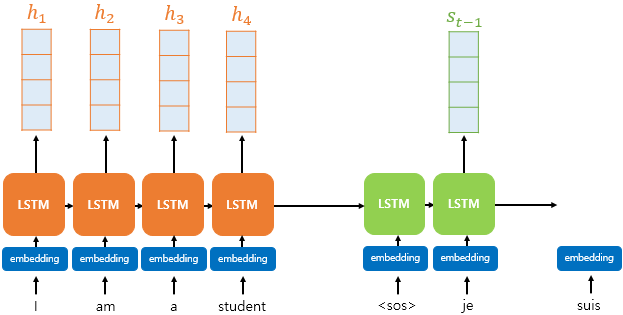

인코더의 시점(time step)을 각각 1, 2, ... N이라고 하였을 때 인코더의 은닉 상태(hidden state)를 각각 h1, h2, h3... hn라고 합시다. 디코더의 현재 시점(time step) t에서의 디코더의 은닉 상태(hidden state)를 st라고 합시다. 또한 여기서는 인코더의 은닉 상태와 디코더의 은닉 상태의 차원이 같다고 가정합니다. 위의 그림의 경우에는 인코더의 은닉 상태와 디코더의 은닉 상태가 동일하게 차원이 4입니다.

앞서 루옹 어텐션에서는 Query로 디코더의 t 시점의 은닉 상태를 사용한 것과는 달리 이번에는 t-1 시점의 은닉 상태 st-1를 사용합니다. 바다나우 어텐션의 어텐션 스코어 함수. 즉, st-1과 인코더의 i번째 은닉 상태의 어텐션 스코어 계산 방법은 아래와 같습니다.

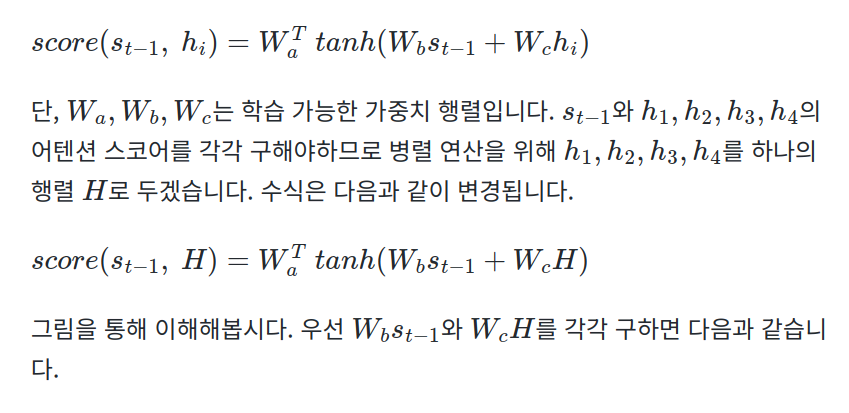

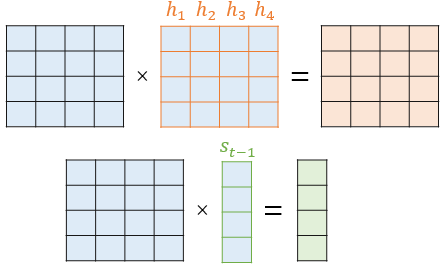

이들을 더한 후, 하이퍼볼릭탄젠트 함수를 지나도록 합니다.

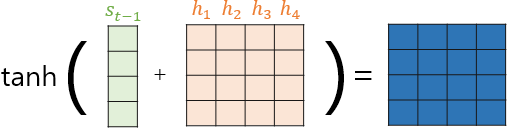

지금까지 진행된 연산의 수식은 다음과 같습니다.

tanh(Wb st-1+Wc H)

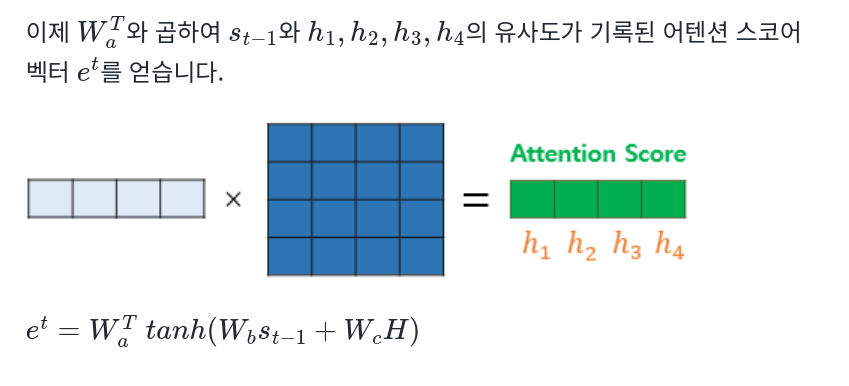

2) 소프트맥스(softmax) 함수를 통해 어텐션 분포(Attention Distribution)를 구한다.

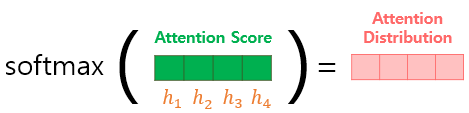

et에 소프트맥스 함수를 적용하여, 모든 값을 합하면 1이 되는 확률 분포를 얻어냅니다. 이를 어텐션 분포(Attention Distribution)라고 하며, 각각의 값은 어텐션 가중치(Attention Weight)라고 합니다.

3) 각 인코더의 어텐션 가중치와 은닉 상태를 가중합하여 어텐션 값(Attention Value)을 구한다.

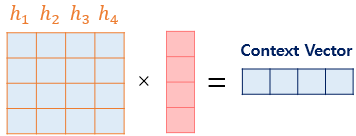

지금까지 준비해온 정보들을 하나로 합치는 단계입니다. 어텐션의 최종 결과값을 얻기 위해서 각 인코더의 은닉 상태와 어텐션 가중치값들을 곱하고, 최종적으로 모두 더합니다. 요약하면 가중합(Weighted Sum)을 한다고 말할 수도 있겠습니다. 이 벡터는 인코더의 문맥을 포함하고 있다고하여, 컨텍스트 벡터(context vector)라고 부릅니다.

4) 컨텍스트 벡터로부터 St를 구합니다.
기존의 LSTM이 St를 구할 때를 아래 그림을 통해 상기해봅시다. 기존의 LSTM은 이전 시점의 셀로부터 전달받은 은닉 상태 St-1와 현재 시점의 입력 xt를 가지고 연산하였습니다. 아래의 LSTM은 seq2seq의 디코더이며 현재 시점의 입력 xt는 임베딩된 단어 벡터입니다.

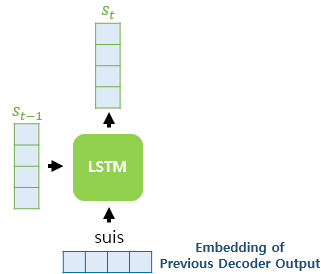

그렇다면 어텐션 메커니즘에서는 어떨까요? 아래의 그림은 바다나우 어텐션 메커니즘에서는 컨텍스트 벡터와 현재 시점의 입력인 단어의 임베딩 벡터를 연결(concatenate)하고, 현재 시점의 새로운 입력으로 사용하는 모습을 보여줍니다. 그리고 이전 시점의 셀로부터 전달받은 은닉 상태 st-1와 현재 시점의 새로운 입력으로부터 s를 구합니다. 기존의 LSTM이 임베딩된 단어 벡터를 입력으로 하는 것에서 컨텍스트 벡터와 임베딩된 단어 벡터를 연결(concatenate)하여 입력으로 사용하는 것이 달라졌습니다.

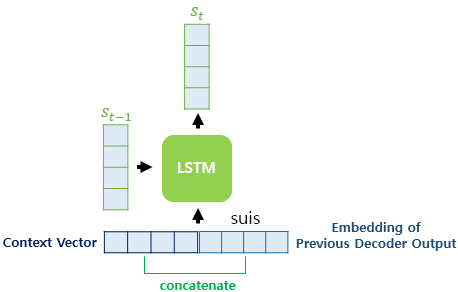

이후에는 어텐션 메커니즘을 사용하지 않는 경우와 동일합니다. st는 출력층으로 전달되어 현재 시점의 예측값을 구하게 됩니다.




In [75]:
dict = {"2017" : "Transformer", "2018" : "BERT"}
print(dict['2017'])
print(dict['2018'])

Transformer
BERT


In [37]:
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import numpy as np
import pandas as pd
import torch
from collections import Counter
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

num_samples = 33000

!wget -c http://www.manythings.org/anki/fra-eng.zip && unzip -o fra-eng.zip

def unicode_to_ascii(s):
  # 프랑스어 악센트(accent) 삭제
  # 예시 : 'déjà diné' -> deja dine
  return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sent):
  # 악센트 삭제 함수 호출
  sent = unicode_to_ascii(sent.lower())

  # 단어와 구두점 사이에 공백을 만듭니다.
  # Ex) "he is a boy." => "he is a boy ."
  sent = re.sub(r"([?.!,¿])", r" \1", sent)

  # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
  sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

  # 다수 개의 공백을 하나의 공백으로 치환
  sent = re.sub(r"\s+", " ", sent)
  return sent

def load_preprocessed_data():
  encoder_input, decoder_input, decoder_target = [], [], []

  with open("fra.txt", "r") as lines:
    for i, line in enumerate(lines):
      # source 데이터와 target 데이터 분리
      src_line, tar_line, _ = line.strip().split('\t')

      # source 데이터 전처리
      src_line = [w for w in preprocess_sentence(src_line).split()]

      # target 데이터 전처리
      tar_line = preprocess_sentence(tar_line)
      tar_line_in = [w for w in ("<sos> " + tar_line).split()]
      tar_line_out = [w for w in (tar_line + " <eos>").split()]

      encoder_input.append(src_line)
      decoder_input.append(tar_line_in)
      decoder_target.append(tar_line_out)

      if i == num_samples - 1:
        break

  return encoder_input, decoder_input, decoder_target

# 전처리 테스트
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous déjà diné?"

print('전처리 전 영어 문장 :', en_sent)
print('전처리 후 영어 문장 :',preprocess_sentence(en_sent))
print('전처리 전 프랑스어 문장 :', fr_sent)
print('전처리 후 프랑스어 문장 :', preprocess_sentence(fr_sent))

sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()
print('인코더의 입력 :',sents_en_in[:5])
print('디코더의 입력 :',sents_fra_in[:5])
print('디코더의 레이블 :',sents_fra_out[:5])


def build_vocab(sents):
  word_list = []

  for sent in sents:
      for word in sent:
        word_list.append(word)

  # 각 단어별 등장 빈도를 계산하여 등장 빈도가 높은 순서로 정렬
  word_counts = Counter(word_list)
  vocab = sorted(word_counts, key=word_counts.get, reverse=True)

  word_to_index = {}
  word_to_index['<PAD>'] = 0
  word_to_index['<UNK>'] = 1

  # 등장 빈도가 높은 단어일수록 낮은 정수를 부여
  for index, word in enumerate(vocab) :
    word_to_index[word] = index + 2

  return word_to_index


src_vocab = build_vocab(sents_en_in)
tar_vocab = build_vocab(sents_fra_in + sents_fra_out)

src_vocab_size = len(src_vocab)
tar_vocab_size = len(tar_vocab)
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

index_to_src = {v: k for k, v in src_vocab.items()}
index_to_tar = {v: k for k, v in tar_vocab.items()}

def texts_to_sequences(sents, word_to_index):
  encoded_X_data = []
  for sent in tqdm(sents):
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

encoder_input = texts_to_sequences(sents_en_in, src_vocab)
decoder_input = texts_to_sequences(sents_fra_in, tar_vocab)
decoder_target = texts_to_sequences(sents_fra_out, tar_vocab)
def pad_sequences(sentences, max_len=None):
    # 최대 길이 값이 주어지지 않을 경우 데이터 내 최대 길이로 패딩
    if max_len is None:
        max_len = max([len(sentence) for sentence in sentences])

    features = np.zeros((len(sentences), max_len), dtype=int)
    for index, sentence in enumerate(sentences):
        if len(sentence) != 0:
            features[index, :len(sentence)] = np.array(sentence)[:max_len]
    return features
encoder_input = pad_sequences(encoder_input)
decoder_input = pad_sequences(decoder_input)
decoder_target = pad_sequences(decoder_target)
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
n_of_val = int(33000*0.1)
print('검증 데이터의 개수 :',n_of_val)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)


--2024-01-14 17:43:33--  http://www.manythings.org/anki/fra-eng.zip
www.manythings.org (www.manythings.org) 해석 중... 173.254.30.110
다음으로 연결 중: www.manythings.org (www.manythings.org)|173.254.30.110|:80... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 416 Requested Range Not Satisfiable

    이미 파일을 완전히 전송했습니다. 할 일 없음.

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 
전처리 전 영어 문장 : Have you had dinner?
전처리 후 영어 문장 : have you had dinner ?
전처리 전 프랑스어 문장 : Avez-vous déjà diné?
전처리 후 프랑스어 문장 : avez vous deja dine ?
인코더의 입력 : [['go', '.'], ['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.']]
디코더의 입력 : [['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'en', 'route', '!'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!']]
디코더의 레이블 : [['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['en', 'route', '!', '<eos>'], ['bouge', '!', '<eos>'], ['salut', '!', '<eos>']]
영어 단어 집합의 크기 : 4488, 프랑스어 단어 집합의 크기 : 7884


100%|█████████████████████████████████| 33000/33000 [00:00<00:00, 360797.52it/s]

인코더의 입력의 크기(shape) : (33000, 7)
디코더의 입력의 크기(shape) : (33000, 16)
디코더의 레이블의 크기(shape) : (33000, 16)
랜덤 시퀀스 : [ 2213 32700  8008 ...  6407  5713 31715]
검증 데이터의 개수 : 3300
훈련 source 데이터의 크기 : (29700, 7)
훈련 target 데이터의 크기 : (29700, 16)
훈련 target 레이블의 크기 : (29700, 16)
테스트 source 데이터의 크기 : (3300, 7)
테스트 target 데이터의 크기 : (3300, 16)
테스트 target 레이블의 크기 : (3300, 16)


In [73]:
import torch
import torch.nn as nn
import torch.optim as opt
embedding_dim=256
hidden_dim=256

class encoder(nn.Module):
    def __init__(self,scr_voacb_size,embedding_dim,hidden_dim):
        super(encoder,self).__init__()
        self.embedding=nn.Embedding(scr_voacb_size,embedding_dim,padding_idx=0)
        self.lstm=nn.LSTM(embedding_dim,hidden_dim,batch_first=True)

    def forward(self,x):
        x=self.embedding(x)
        output,(hidden,cell)=self.lstm(x)
        return output,hidden,cell


class decoder(nn.Module):
    def __init__(self,tar_voacb_size,embedding_dim,hidden_dim):
        super(decoder,self).__init__()
        self.embedding=nn.Embedding(tar_voacb_size,embedding_dim,padding_idx=0)
        self.lstm=nn.LSTM(embedding_dim,hidden_dim,batch_first=True)
        self.cf=nn.Linear(hidden_dim,tar_vocab_size)
        self.softmax=nn.Softmax(dim=2)

    def forward(self,x,encoder_output,hidden,cell):
        x=self.embedding(x)
        attention_score=torch.bmm(encoder_output,hidden.transpose(0,1).transpose(1,2))
        attention_weight=self.softmax(attention_score)
        context_vec=torch.bmm(attention_weight.transpose(1,2),encoder_output)
        seq_len=x.shape[1]
        context_vec_repeat=context_vec.repeat(1,seq_len,1)

        
        x=torch.cat((x,context_vec_repeat),dim=2)
        output,(hidden,cell)=self.lstm(x,(hidden,cell))
        output=self.cf(output)
        return output,hidden,cell

class seq2seq(nn.Module):
    def __init__(self,encoder,decoder):
        super(seq2seq,self).__init__()
        self.encoder=encoder
        self.decoder=decoder

    def forward(self,src,trg):
        encoder_output,hidden,cell=self.encoder(src)
        output,_,_=self.decoder(trg,encoder_output,hidden,cell)
        return output

encoder=encoder(src_vocab_size,embedding_dim,hidden_dim)
decoder=decoder(tar_vocab_size,embedding_dim,hidden_dim)
model=seq2seq(encoder,decoder)

loss_f=nn.CrossEntropyLoss()
opt=opt.Adam(model.parameters(),lr=0.001)

In [74]:
def evalu(model,loader,loss_f,device):
    model.eval()
    total_loss=0
    total_correct=0
    total_count=0

    with torch.no_grad():
        for encoder_input,decoder_input,decoder_ratget in loader:
            encoder_input=encoder_input.to(device)
            decoder_input=decoder_input.to(device)
            decoder_target=decoder_target.to(device)
            output=model(encoder_input,decoder_input)
            loss=loss_f(output.view(-1,output.size(-1)),decoder_target.view(-1))
            total_loss+=loss.item()
            mask=decoder_target !=0
            total_correct+=((output.argmax(dim=-1)==decoder_target)*mask).sum().item()
            total_correct+=mask.sum().item()

    return total_loss/len(loader),total__correct/total_count

encoder_input_train_tensor=torch.tensor(encoder_input_train,dtype=torch.long)
decoder_input_train_tensor=torch.tensor(decoder_input_train,dtype=torch.long)
decoder_target_train_tensor=torch.tensor(decoder_target_train,dtype=torch.long)

encoder_input_test_tensor=torch.tensor(encoder_input_test,dtype=torch.long)
decoder_input_test_tensor=torch.tensor(decoder_input_test,dtype=torch.long)
decoder_target_test_tensor=torch.tensor(decoder_target_test,dtype=torch.long)

batch_size=1028

train_dataset=TensorDataset(encoder_input_train_tensor,decoder_input_train_tensor,decoder_target_train_tensor)
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

valid_dataset = TensorDataset(encoder_input_test_tensor, decoder_input_test_tensor, decoder_target_test_tensor)
valid_loader=DataLoader(valid_dataset,batch_size=batch_size,shuffle=False)

num_epochs=300
device=torch.device('cuda'if torch.cuda.is_available()else 'cpu')

print(f"{device} mode")
model.to(device)

best_val_loss=float('inf')

for epoch in range(num_epochs):
    model.train()
    for encoder_input,decoder_input,decoder_traget in train_loader:
        encoder_input=encoder_input.to(device)
        decoder_input=decoder_input.to(device)
        decoder_traget=decoder_traget.to(device)
        output=model(encoder_input,decoder_input)
        
        loss=loss_f(output.view(-1,output.size(-1)),decoder_target.view(-1))
        opt.zero_grad()
        loss.backward()
        opt.step()

    train_loss,train_acc = evalu(model,train_loader,loss_f,device)
    valid_loss,valid_acc=evalu(model,valid_loader,loss_f,device)
    
    print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}')
    
    if valid_loss<best_var_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {valid_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss=valid_loss
        torch.save(model.state_dict(),'best_model_checkpoint.pth')



cuda mode


RuntimeError: input.size(-1) must be equal to input_size. Expected 256, got 512

In [ ]:
model.load_state_dict(torch.load('best_model_checkpoint.pth'))
model.to(device)
val_loss,val_acc=evalu(model.valid_loader,loss_f,device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}'

print(tar_vocab['<sos>'])
print(tar_vocab['<eos>'])


In [ ]:
# seq2seq 기계 번역기 동작시키기
index_to_scr={v:k for k,v in scr_vocab.items()}
index_to_tar={v:k for k,v in tar_vocab.items()}

def seq2src(input_seq):
    sentence=' '
    for encoder_word in input_seq:
        if (encoder_word!=0):
            sentence=sentence+index_to_src[encoder_word]
    return sentence

def seq2tar(input_seq):
    sentence=' '
    for encoder_word in input_seq:
        if(encoder_word!=0 and encoder_word!=tar_vocab['<sos>'] and encoder_word!=tar_vocab['<eos>']):
            sentense=sentence+index_to_tar[encoder_word]+' '
    return sentence

print(encoder_input_test[25])
print(decoder_input_test[25])
print(decoder_target_test[25])


def decoder_seq(input_seq,src_vocab_size,tar_vocab_size,max_output_len,int_to_scr_token,index_to_tar_token):
    encoder_input=torch.tensor(input_seq,dtype=torch.long).unsqueeze(0),to(device)
    encoder_output,hidden,cell=model.encoder(encoder_input)
    decoder_input=torch.tensor([3],dtype=torch.long).unsqueeze(0).to(device)
    decoder_token=[]
    for _ in range(max_output_len):
        output,hidden,cell=model.decoder_input,encoder_output,hidden,cell
        output_token=output.argmax(dim=-1).item()
        if output_token == 4:
            break

        decoder_token.append(output_token)
        decoder_input=torch.tensor([output_token],dtype=torch.long).unsqueeze(0).to(device)
    return ' '.join(int_to_token[token]for toekn in decoder)



for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_train[seq_index]
  translated_text = decode_sequence(input_seq, model, src_vocab_size, tar_vocab_size, 20, index_to_src, index_to_tar)

  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",translated_text)
  print("-"*50)


for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_test[seq_index]
  translated_text = decode_sequence(input_seq, model, src_vocab_size, tar_vocab_size, 20, index_to_src, index_to_tar)

  print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_test[seq_index]))
  print("번역문장 :",translated_text)
  print("-"*50)
